# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


in bash shell in the current working directory type 

```bash
unzip train_val-20240219T160046Z-001.zip && rm train_val-20240219T160046Z-001
```

In [1]:
#
# Add your code here
#
# from google.colab import drive

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
# drive.mount('/content/drive')
# paths=['/content/drive/MyDrive/train_val']


# set this to the path where you unzip the Google Driver zip download
# in bash shell in the current working directory type `unzip train_val-20240219T160046Z-001.zip && rm train_val-20240219T160046Z-001`
path='./train_val'

images = []
ages = []
genders = [] 

files = os.listdir(path)
i=0
for file in files:
  i=i+1
  age = file.split("_")[0]
  gender = file.split("_")[1]
  if i % 500 == 0:
    print("File: %s, Age: %s, Gender: %s" %(file, age, gender))
  # if gender != '0' and gender != '1':
  #   print(img)
  img = cv2.imread(path+"/"+file)
  img = cv2.resize(img,(128,128))
  images.append(np.array(img))
  genders.append(np.array(gender))
  ages.append(np.array(age))
    # if i == 100:
    #   break
images = np.array(images,np.float32)
genders = np.array(genders,np.int64)
ages = np.array(ages,np.int64)
images.shape

File: 35_1_1_20170117190321049.jpg.chip.jpg, Age: 35, Gender: 1
File: 24_0_0_20170116220755400.jpg.chip.jpg, Age: 24, Gender: 0
File: 1_0_2_20170116194202388.jpg.chip.jpg, Age: 1, Gender: 0
File: 50_0_3_20170119195746908.jpg.chip.jpg, Age: 50, Gender: 0
File: 26_1_1_20170116160918398.jpg.chip.jpg, Age: 26, Gender: 1
File: 86_1_0_20170110180108013.jpg.chip.jpg, Age: 86, Gender: 1
File: 16_1_0_20170117193255060.jpg.chip.jpg, Age: 16, Gender: 1
File: 35_0_0_20170116233057278.jpg.chip.jpg, Age: 35, Gender: 0
File: 43_0_1_20170104185752431.jpg.chip.jpg, Age: 43, Gender: 0
File: 34_1_3_20170105001226421.jpg.chip.jpg, Age: 34, Gender: 1


(5000, 128, 128, 3)

## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

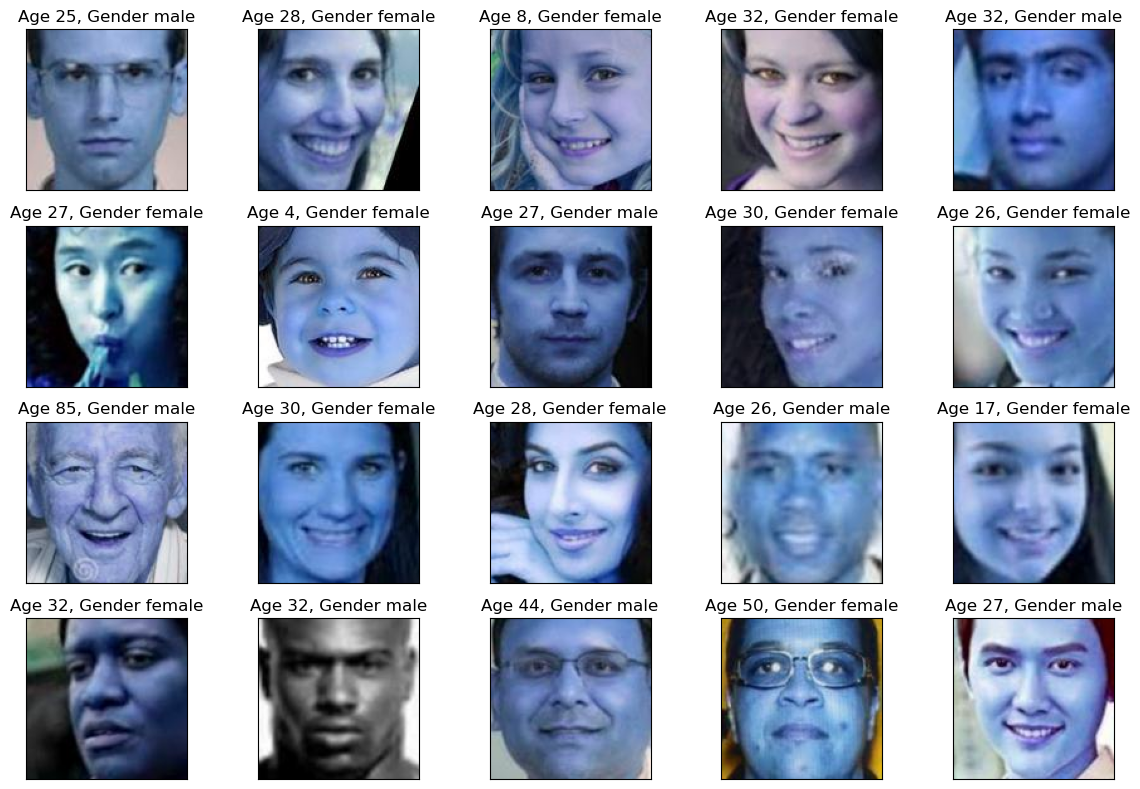

In [2]:
#
# Add your code here
# why would you ever do the plotting/display before ## STEP1: Data pre-processing
# imshow only works on data scaled between 0 and 1 so do pre-processing first
pixels2 = images/255

my_arr = np.array(range(0,20)).reshape((4,5))
gender_dict = {0:'male', 1:'female'}
fig, ax = plt.subplots(4, 5, figsize=(12,8))

for i in range(0,4):
  for j in range(0,5):
    # print(my_arr[i][j])
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])
    ax[i][j].grid(False)
    ax[i][j].imshow(pixels2[my_arr[i][j]])
    ax[i][j].set_title("Age %d, Gender %s" % (ages[my_arr[i][j]], gender_dict[genders[my_arr[i][j]]]))
fig.tight_layout()

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [3]:
#
# Add your code here
#
from sklearn.model_selection import train_test_split

(x_train, x_test,
 y_train_gender, y_test_gender,
 y_train_age, y_test_age) = train_test_split(*[images,genders,ages],random_state=100,train_size=0.80, stratify=genders)

x_train=x_train/255
x_test=x_test/255
print(x_train.shape, x_test.shape, np.unique(y_train_gender, return_counts=True))
print(np.unique(y_train_gender, return_counts=True),
      np.unique(y_test_gender, return_counts=True),
      len(np.unique(ages)))

# Pre-processing using augmentation is done DURING training.  See top of `make_upstream(...)` below

(4000, 128, 128, 3) (1000, 128, 128, 3) (array([0, 1]), array([2067, 1933]))
(array([0, 1]), array([2067, 1933])) (array([0, 1]), array([517, 483])) 96


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

[data_augmenter](https://github.com/berkayalan/neural-networks-and-deep-learning/blob/master/Transfer_learning_with_MobileNet_v1.ipynb)

#### Forget this below since augmenting during training is better

## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

2024-03-16 16:50:31.694827: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-16 16:50:31.718157: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 16:50:31.718186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 16:50:31.719037: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-16 16:50:31.725149: I tensorflow/core/platform/cpu_feature_guar

Number filters per Conv2d layer:16
Number filters per Conv2d layer:32
Number filters per Conv2d layer:64
Number filters per Conv2d layer:128
Number filters per Conv2d layer:256
Number filters per Conv2d layer:16
Number filters per Conv2d layer:32
Number filters per Conv2d layer:64
Number filters per Conv2d layer:128
Number filters per Conv2d layer:256


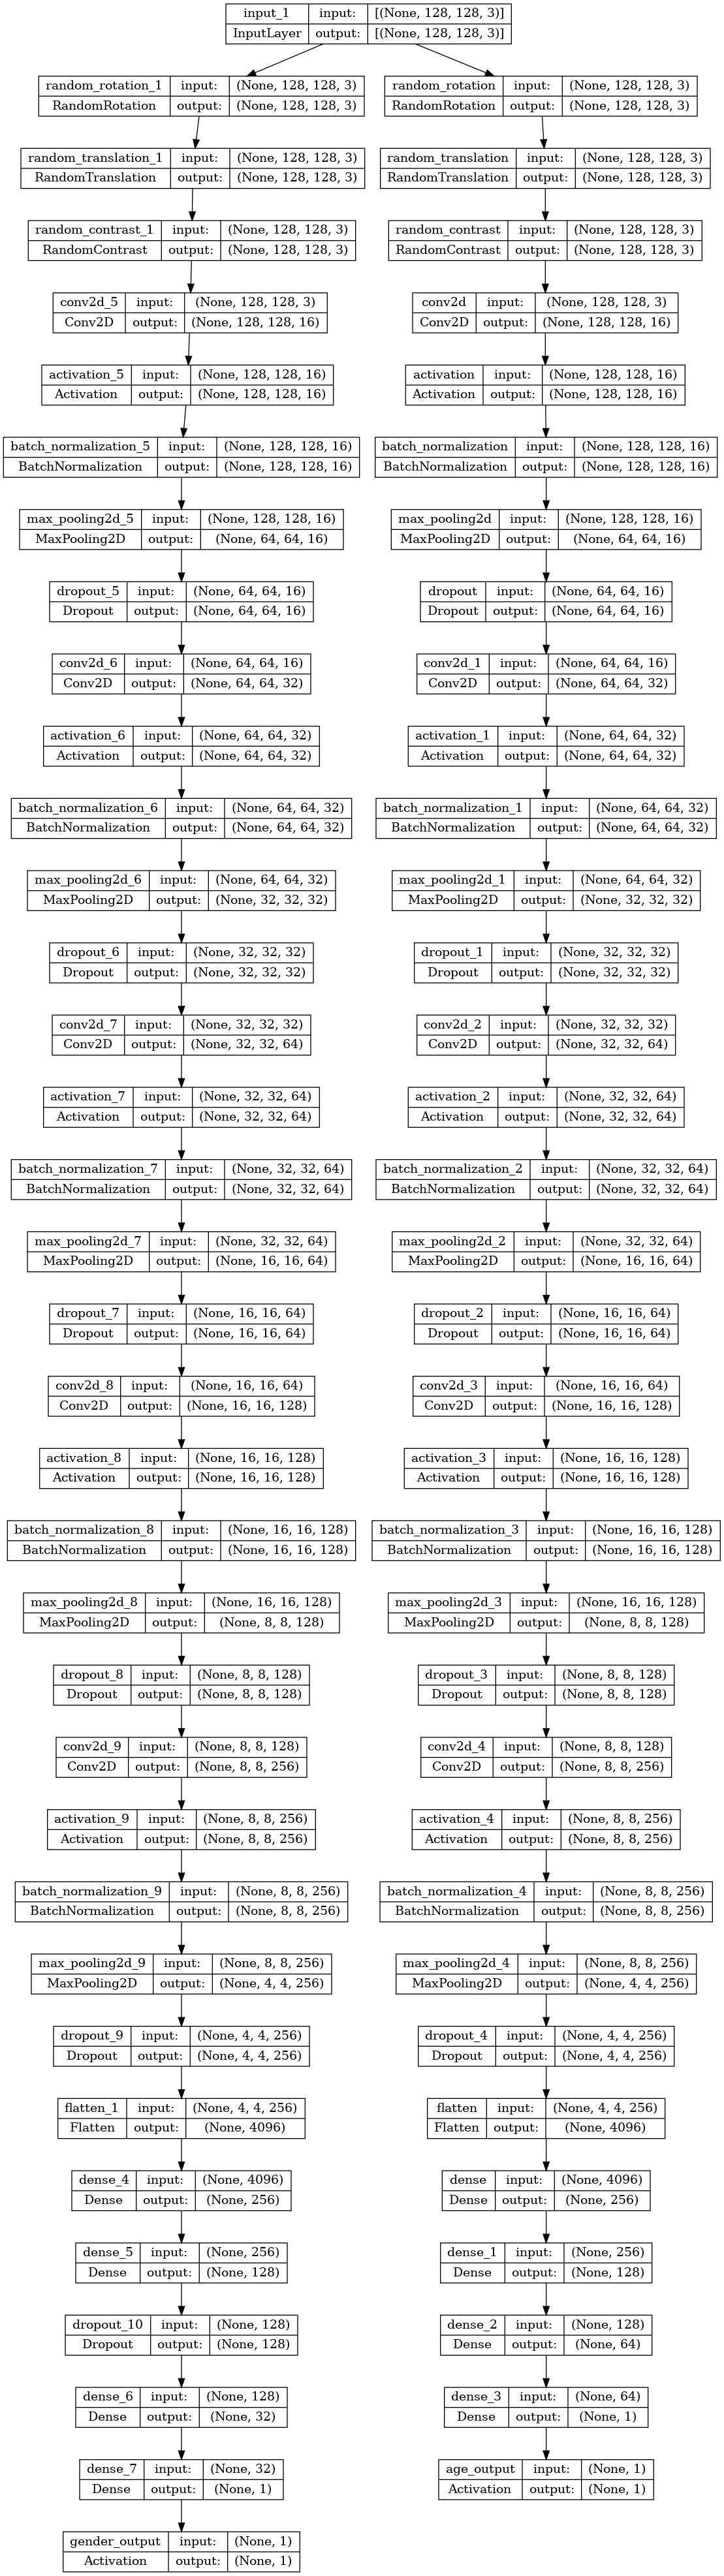

In [5]:
#
# Add your code here
#

# Import dependencies
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input,Activation
from tensorflow.keras import layers 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


def make_upstream(inputs, no_of_conv_layers=(16,32)):
    '''
    This is the "tail" if using language of queue data-structure or 
    "top" if using language of a stack data-structure
    of the model
    '''
    x=inputs
    x=layers.RandomRotation(factor=0.04)(x)
    x=layers.RandomTranslation(height_factor=0.0960, width_factor=0.0960)(x)
    # x=layers.RandomFlip()(x)
    x=layers.RandomContrast(factor=0.01)(x)

    for filters in no_of_conv_layers:
        print("Number filters per Conv2d layer:%s" % filters)
        x=Conv2D(filters=filters, kernel_size=(3,3), padding='same', strides=(1, 1), kernel_regularizer=l2(0.001))(x)
        x=Activation('relu')(x)
        x=BatchNormalization(axis=-1)(x)
        x=MaxPooling2D(pool_size = (2,2))(x)
        x=Dropout(0.15)(x) # increase from 0.1 to decrease overfitting

    return x


def build_age_branch(inputs, no_of_conv_layers=(16,32)):
    '''
    This is the age_branch of the model, bottom if queue or "header" if stack
    '''
    x=make_upstream(inputs, no_of_conv_layers)
    x=Flatten()(x)
    x=Dense(256,activation='relu')(x)
    x=Dense(128,activation='relu')(x)
    x=Dense(64,activation='relu')(x) #116 ages
    x=Dense(1)(x)
    x=Activation("linear", name="age_output")(x)
    
    return x


def build_gender_branch(inputs, no_of_conv_layers=(16,32)):
    '''
    This is the gender_branch of the model, bottom if queue or "header" if stack
    '''
    x=make_upstream(inputs, no_of_conv_layers)
    x=Flatten()(x)
    x=Dense(256,activation='relu')(x)
    x=Dense(128,activation='relu')(x)
    x=Dropout(0.2)(x)
    x=Dense(32,activation='relu')(x)
    x=Dense(1)(x)
    x=Activation("sigmoid", name="gender_output")(x)
    
    return x


input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)
age_branch = build_age_branch(inputs, no_of_conv_layers=(16,32,64,128,256)) # inputs needs to be same memory address
gender_branch = build_gender_branch(inputs, no_of_conv_layers=(16,32,64,128,256))

modelA = Model(inputs=inputs,
               outputs = [gender_branch, age_branch],
               name="faces")

from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [6]:
#
# Add your code here
#

num_epochs=200
# model_folder='output/'
# checkpoint_filepath = 'output/checkpoint.age_gender_A.h5' # will rename to age_gender_A.h5 file on GDrive
checkpoint_filepath = 'output/checkpoint.age_gender_A1.h5' # will rename to age_gender_A.h5 file on GDrive
checkpointer = ModelCheckpoint(checkpoint_filepath, 
                               monitor='val_gender_output_accuracy', 
                               verbose=1, 
                               save_best_only=True,
                               save_weights_only=False, 
                               mode='auto', 
                               save_freq='epoch')
callback_early=keras.callbacks.EarlyStopping(monitor='loss',patience=60)

callback_list=[checkpointer, callback_early]

modelA.compile(optimizer=Adam(learning_rate=0.0011),
               loss={'gender_output':'binary_crossentropy',
                     'age_output':'mse'},
               metrics={'gender_output':'accuracy',
                        'age_output':'mae'})

modelA.fit(x=x_train,
           y={"gender_output": y_train_gender, "age_output": y_train_age},#, steps_per_epoch=125, validation_batch_size=32,
           validation_data=(x_test, {"gender_output": y_test_gender, "age_output": y_test_age}),
           epochs=num_epochs, callbacks=[callback_list], batch_size=32)

# modelA.save('output/checkpoint.age_gender_A.h5') # will just move the checkpoint file here

# save for plotting training later after MANY iterations of traing to optimize layers and augementation
historyA = modelA.history.history
# with open('output/checkpoint.age_gender_A.dict', 'wb') as file_pi:
with open('output/checkpoint.age_gender_A1.dict', 'wb') as file_pi:
    pickle.dump(historyA, file_pi)

Epoch 1/200


2024-03-16 16:50:38.250480: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infaces/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-16 16:50:39.259920: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-16 16:50:41.121243: I external/local_xla/xla/service/service.cc:168] XLA service 0x7accd5f96010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-16 16:50:41.121273: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-03-16 16:50:41.125877: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710607841.201711   10446 device_compiler.h:186] Compiled cluster us

125/125 [==============================] - ETA: 0s - loss: 381.0868 - gender_output_loss: 0.7136 - age_output_loss: 379.6953 - gender_output_accuracy: 0.6390 - age_output_mae: 14.9270
Epoch 1: val_gender_output_accuracy improved from -inf to 0.51700, saving model to output/checkpoint.age_gender_A1.h5


/home/coyote/miniconda3/envs/cnn_proj/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 21s 67ms/step - loss: 381.0868 - gender_output_loss: 0.7136 - age_output_loss: 379.6953 - gender_output_accuracy: 0.6390 - age_output_mae: 14.9270 - val_loss: 583.4474 - val_gender_output_loss: 0.8357 - val_age_output_loss: 581.9290 - val_gender_output_accuracy: 0.5170 - val_age_output_mae: 18.5404
Epoch 2/200
125/125 [==============================] - ETA: 0s - loss: 264.9214 - gender_output_loss: 0.5690 - age_output_loss: 263.6671 - gender_output_accuracy: 0.7153 - age_output_mae: 12.2893
Epoch 2: val_gender_output_accuracy improved from 0.51700 to 0.60800, saving model to output/checkpoint.age_gender_A1.h5
125/125 [==============================] - 7s 58ms/step - loss: 264.9214 - gender_output_loss: 0.5690 - age_output_loss: 263.6671 - gender_output_accuracy: 0.7153 - age_output_mae: 12.2893 - val_loss: 527.7141 - val_gender_output_loss: 0.6263 - val_age_output_loss: 526.4022 - val_gender_output_accuracy: 0.6080 - val_age_output_mae: 17.613

In [7]:
# SANITY CHECK: confirm the validation works when loading file from GDrive and get same numbers as in report

checkpoint_filepath = 'output/age_gender_A.h5'
modelA = load_model(checkpoint_filepath)
modelA.evaluate(x_test, {"gender_output": y_test_gender, "age_output": y_test_age})

32/32 [==============================] - 1s 18ms/step - loss: 88.3533 - gender_output_loss: 0.2337 - age_output_loss: 82.3261 - gender_output_accuracy: 0.9090 - age_output_mae: 6.5112


[88.35334777832031,
 0.23374685645103455,
 82.32614135742188,
 0.9089999794960022,
 6.511195659637451]

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


Best Accuracy: 0.909000, Best MAE at best Accuracy: 6.511140


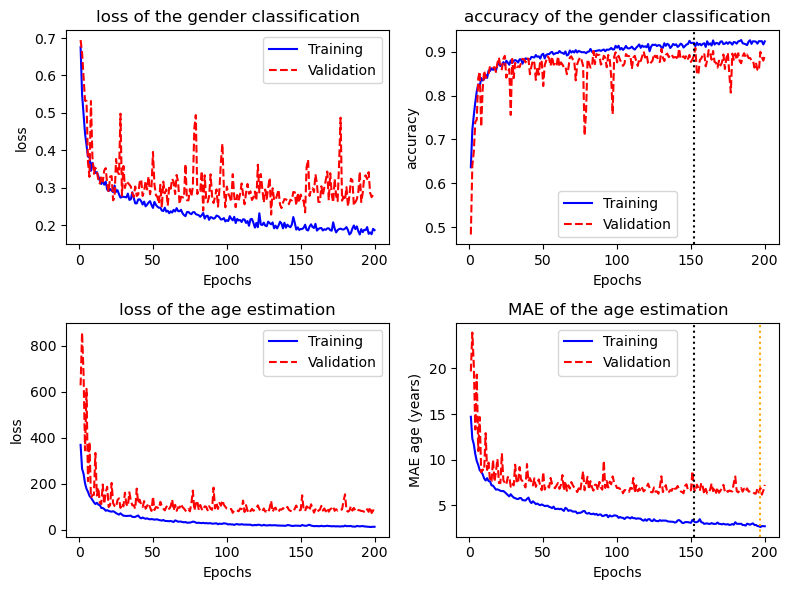

In [9]:
#
# Add your code here
# 

with open('output/checkpoint.age_gender_A.dict', "rb") as file_pi:
    historyA = pickle.load(file_pi)

higest_acc = np.where(np.array(historyA['val_gender_output_accuracy'])==max(historyA['val_gender_output_accuracy']))[0]
print("Best Accuracy: %f, Best MAE at best Accuracy: %f" % (historyA['val_gender_output_accuracy'][higest_acc[0]],
                                                            historyA['val_age_output_mae'][higest_acc[0]]))
lowest_mae = np.where(np.array(historyA['val_age_output_mae'])==min(historyA['val_age_output_mae']))[0]

plots = [
    [[historyA['gender_output_loss'],historyA['val_gender_output_loss']],
     [historyA['gender_output_accuracy'],historyA['val_gender_output_accuracy']]],
    [[historyA['age_output_loss'],historyA['val_age_output_loss']],
     [historyA['age_output_mae'],historyA['val_age_output_mae']]]
]

y_axis = [['loss', 'accuracy'],
          ['loss', 'MAE age (years)']]

titles = [['loss of the gender classification', 'accuracy of the gender classification'],
          ['loss of the age estimation', 'MAE of the age estimation']]

fig, ax = plt.subplots(2,2, figsize=(8,6))

for i in range(0,2):
    for j in range(0,2):
        ax[i][j].plot(range(1,len(historyA['gender_output_loss'])+1),plots[i][j][0], label='Training', linestyle='-', color='blue')
        ax[i][j].plot(range(1,len(historyA['gender_output_loss'])+1),plots[i][j][1], label='Validation', linestyle='--', color='red')
        if j == 1:
            ax[i][j].axvline(higest_acc, 0,1, linestyle=':', color='black')
            if i == 1:
                ax[i][j].axvline(lowest_mae, 0,1, linestyle=':', color='orange')
        ax[i][j].set_xlabel('Epochs')
        ax[i][j].set_ylabel(y_axis[i][j])
        ax[i][j].set_title(titles[i][j])
        ax[i][j].legend()
fig.tight_layout()

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


<keras.src.engine.input_layer.InputLayer object at 0x7ad087004910> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7acee4c76210> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7acd100630d0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7acd881f7450> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7acd10069390> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7acd881f84d0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7acee7979950> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7accd873da10> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7accd87dc890> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7accd87e3c10> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7acf582278d0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7acd10111790> False
<keras.src.layers.convolutional.conv2d.Conv2D ob

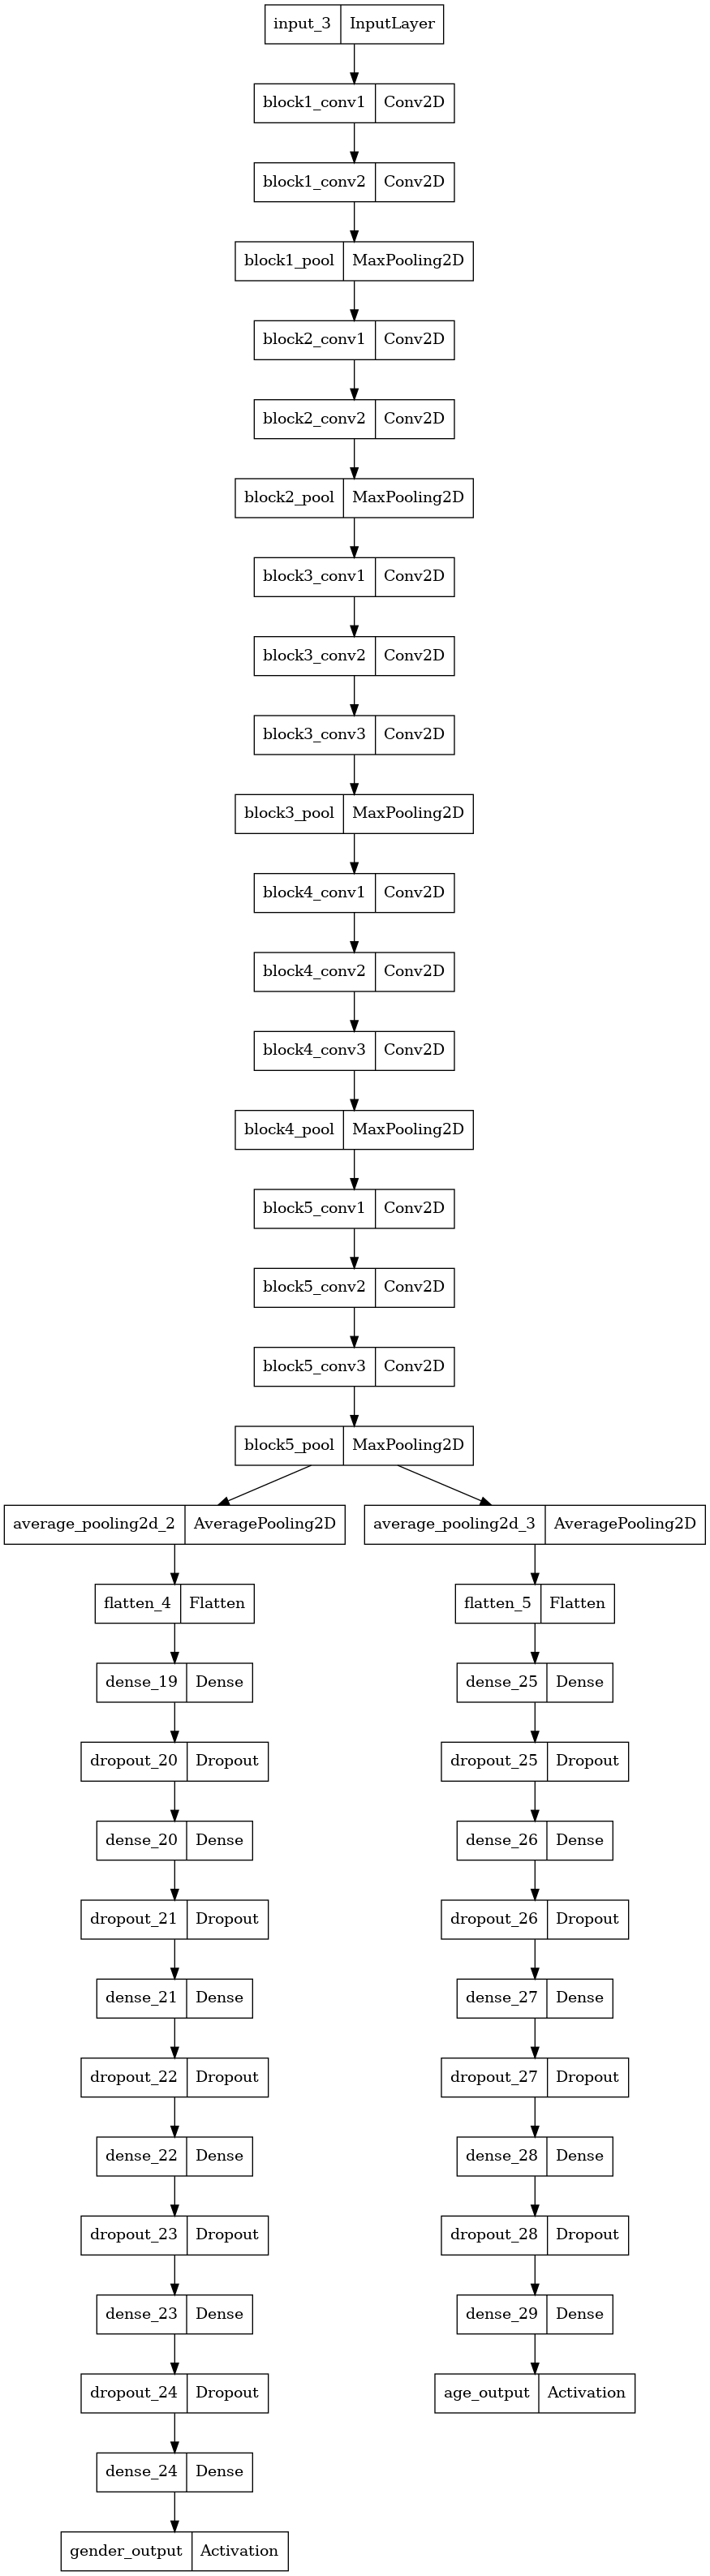

In [13]:
#
# Add your code here
#

# Import dependencies
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16, VGG19


input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)


modelB = VGG16(include_top=False, 
                weights='imagenet', 
                input_tensor=inputs,
                input_shape=input_shape, 
                pooling=None, 
                classes=2,
                classifier_activation='softmax')

## Train last 4 layers and freeze top 14
n_bottom=4
n_top=0
for layer in modelB.layers[:n_top]:
    layer.trainable = True
for layer in modelB.layers[n_top:-n_bottom]:
    layer.trainable = False
for layer in modelB.layers[-n_bottom:]:
    layer.trainable = True
for layer in modelB.layers:
    print(layer, layer.trainable)


from tensorflow import keras
from tensorflow.keras.layers import AveragePooling2D



modelB.compile(optimizer=Adam(),loss='sparse_categorical_crossentropy', metrics='accuracy')

# head model
headModel=modelB.output

# gender branch
headModel_gender=AveragePooling2D(pool_size=(2,2))(headModel)
headModel_gender=Flatten()(headModel_gender)
## this seems to work better than using the 4096 for ImageNet
headModel_gender=Dense(2048,activation='relu',
                       kernel_initializer=keras.initializers.GlorotUniform(seed=100),
                       bias_initializer=keras.initializers.Zeros())(headModel_gender)
headModel_gender=Dropout(0.2)(headModel_gender)
headModel_gender=Dense(1024,activation='relu',
                       kernel_initializer=keras.initializers.GlorotUniform(seed=100),
                       bias_initializer=keras.initializers.Zeros())(headModel_gender)
headModel_gender=Dropout(0.1)(headModel_gender)
headModel_gender=Dense(512,activation='relu',
                       kernel_initializer=keras.initializers.GlorotUniform(seed=100),
                       bias_initializer=keras.initializers.Zeros())(headModel_gender)
headModel_gender=Dropout(0.1)(headModel_gender)
headModel_gender=Dense(128,activation='relu',
                       kernel_initializer=keras.initializers.GlorotUniform(seed=100),
                       bias_initializer=keras.initializers.Zeros())(headModel_gender)
headModel_gender=Dropout(0.)(headModel_gender)
headModel_gender=Dense(64,activation='relu',
                       kernel_initializer=keras.initializers.GlorotNormal(seed=100),
                       bias_initializer=keras.initializers.Zeros())(headModel_gender)
headModel_gender=Dropout(0.1)(headModel_gender)
headModel_gender=Dense(1)(headModel_gender)
headModel_gender=Activation("sigmoid", name="gender_output")(headModel_gender)

# age branch
headModel_age=AveragePooling2D(pool_size=(4,4))(headModel)
headModel_age=Flatten()(headModel_age)
headModel_age=Dense(2048,activation='relu')(headModel_age)
headModel_age=Dropout(0.2)(headModel_age)
headModel_age=Dense(1024,activation='relu')(headModel_age)
headModel_age=Dropout(0.2)(headModel_age)
headModel_age=Dense(512,activation='relu')(headModel_age)
headModel_age=Dropout(0.2)(headModel_age)
headModel_age=Dense(64,activation='relu')(headModel_age)
headModel_age=Dropout(0.2)(headModel_age)
headModel_age=Dense(1)(headModel_age)
headModel_age=Activation("linear", name="age_output")(headModel_age)

modelB = Model(inputs=modelB.input, outputs=[headModel_gender, headModel_age])

plot_model(modelB)

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [14]:
#
# Add your code here
#

from tensorflow import keras
import numpy as np
from tensorflow.keras import layers 

## required for flowing multiple outputs
img_augmentation_layers = [
    layers.RandomRotation(factor=0.05),
    layers.RandomTranslation(height_factor=0.05, width_factor=0.05),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.05),
]

def img_augmentation(images):
  for layer in img_augmentation_layers:
    images = layer(images)
  return images

class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    '''
    Way to go GOOGLE.  Keep up the "great" work.  Ugh. :( https://github.com/keras-team/keras/issues/12639
    And also why deprecate `ImageDataGenerator`, as making folder structures is more of a PAIN!!!!!
    '''
    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):
        
        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            flowx=img_augmentation(flowx) # faster to do this on a flow of a batch then each image indiv in a `preprocessing_function`
            target_dict = {}
            i = 0

            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

## git training data to generator
datagen = MultiOutputDataGenerator()
datagen.fit(x_train)


# checkpoint_filepath = 'output/checkpoint.age_gender_B.h5'  # will just move to age_gender_B.h5 in GDrive
checkpoint_filepath = 'output/checkpoint.age_gender_B1.h5'  # will just move to age_gender_B.h5 in GDrive
callback_early=keras.callbacks.EarlyStopping(monitor='val_gender_output_accuracy',patience=30)
checkpointer = ModelCheckpoint(checkpoint_filepath, monitor='val_gender_output_accuracy', verbose=1, save_best_only=True,
                               save_weights_only=False, mode='auto', save_freq='epoch')
callback_list=[checkpointer, callback_early]


num_epochs=200
import pickle

modelB.compile(optimizer=Adam(learning_rate=0.0001,amsgrad=False),
               loss={'gender_output':'binary_crossentropy',
                     'age_output':'mse'},
               metrics={'gender_output':'accuracy',
                        'age_output':'mae'})
modelB.fit(datagen.flow(x_train, y={"gender_output": y_train_gender.reshape((-1,1)), "age_output": y_train_age.reshape((-1,1))}, batch_size=32),
            steps_per_epoch=125,
           validation_data=(x_test, {"gender_output": y_test_gender, "age_output": y_test_age}),
           epochs=num_epochs, callbacks=[callback_list], validation_batch_size=8)

historyB = modelB.history.history

# modelB.save('output/checkpoint.age_gender_B.h5') # will just move the checkpoint file here

# save for plotting training later after MANY iterations of traing to optimize layers and augementation
# with open('output/checkpoint.age_gender_B.dict', 'wb') as file_pi:
with open('output/checkpoint.age_gender_B1.dict', 'wb') as file_pi:
    pickle.dump(historyB, file_pi)

Epoch 1/200
125/125 [==============================] - ETA: 0s - loss: 365.8422 - gender_output_loss: 0.7083 - age_output_loss: 365.1339 - gender_output_accuracy: 0.5610 - age_output_mae: 14.5155
Epoch 1: val_gender_output_accuracy improved from -inf to 0.59500, saving model to output/checkpoint.age_gender_B1.h5


/home/coyote/miniconda3/envs/cnn_proj/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 18s 119ms/step - loss: 365.8422 - gender_output_loss: 0.7083 - age_output_loss: 365.1339 - gender_output_accuracy: 0.5610 - age_output_mae: 14.5155 - val_loss: 225.7593 - val_gender_output_loss: 0.6764 - val_age_output_loss: 225.0830 - val_gender_output_accuracy: 0.5950 - val_age_output_mae: 12.3734
Epoch 2/200
125/125 [==============================] - ETA: 0s - loss: 195.0204 - gender_output_loss: 0.6567 - age_output_loss: 194.3638 - gender_output_accuracy: 0.6210 - age_output_mae: 10.5720
Epoch 2: val_gender_output_accuracy improved from 0.59500 to 0.63100, saving model to output/checkpoint.age_gender_B1.h5
125/125 [==============================] - 16s 125ms/step - loss: 195.0204 - gender_output_loss: 0.6567 - age_output_loss: 194.3638 - gender_output_accuracy: 0.6210 - age_output_mae: 10.5720 - val_loss: 140.1411 - val_gender_output_loss: 0.6468 - val_age_output_loss: 139.4943 - val_gender_output_accuracy: 0.6310 - val_age_output_mae: 8.4

In [ ]:
# SANITY CHECK: confirm the validation works when loading file from GDrive and matches numbers in report.

checkpoint_filepath = 'output/age_gender_B.h5'
modelB = load_model(checkpoint_filepath)
modelB.evaluate(x_test, {"gender_output": y_test_gender, "age_output": y_test_age})

32/32 [==============================] - 3s 80ms/step - loss: 78.6229 - gender_output_loss: 0.3458 - age_output_loss: 78.2772 - gender_output_accuracy: 0.8810 - age_output_mae: 6.3163


2024-03-16 16:39:25.787954: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-16 16:39:25.788014: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-16 16:39:25.867174: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-16 16:39:25.867212: W external/local_tsl/tsl/framework/bfc_

[78.62294006347656,
 0.3457639515399933,
 78.27717590332031,
 0.8809999823570251,
 6.316266059875488]

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

Best Accuracy: 0.881000, Best MAE at best Accuracy: 6.316417


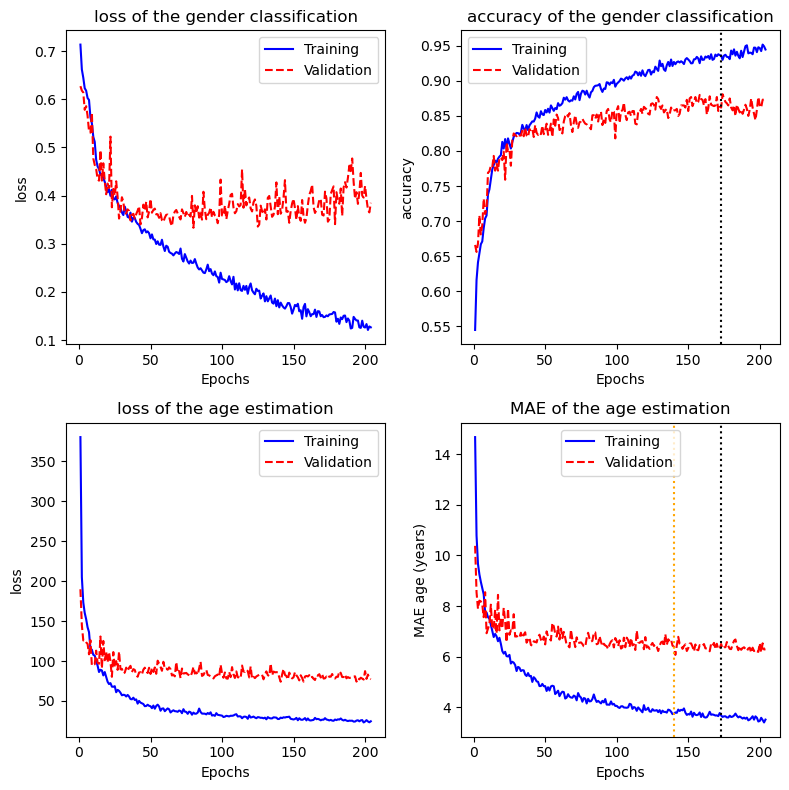

In [ ]:
#
# Add your code here
#
with open('output/checkpoint.age_gender_B.dict', "rb") as file_pi:
    historyB = pickle.load(file_pi)

print("Best Accuracy: %f, Best MAE at best Accuracy: %f" % (historyB['val_gender_output_accuracy'][higest_acc[0]],
                                                            historyB['val_age_output_mae'][higest_acc[0]]))
higest_acc = np.where(np.array(historyB['val_gender_output_accuracy'])==max(historyB['val_gender_output_accuracy']))[0]
lowest_mae = np.where(np.array(historyB['val_age_output_mae'])==min(historyB['val_age_output_mae']))[0]

plots = [
    [[historyB['gender_output_loss'],historyB['val_gender_output_loss']],
     [historyB['gender_output_accuracy'],historyB['val_gender_output_accuracy']]],
    [[historyB['age_output_loss'],historyB['val_age_output_loss']],
     [historyB['age_output_mae'],historyB['val_age_output_mae']]]
]

y_axis = [['loss', 'accuracy'],
          ['loss', 'MAE age (years)']]

titles = [['loss of the gender classification', 'accuracy of the gender classification'],
          ['loss of the age estimation', 'MAE of the age estimation']]

fig, ax = plt.subplots(2,2, figsize=(8,8))

for i in range(0,2):
    for j in range(0,2):
        ax[i][j].plot(range(1,len(historyB['gender_output_loss'])+1),plots[i][j][0], label='Training', linestyle='-', color='blue')
        ax[i][j].plot(range(1,len(historyB['gender_output_loss'])+1),plots[i][j][1], label='Validation', linestyle='--', color='red')
        if j == 1:
            ax[i][j].axvline(higest_acc, 0,1, linestyle=':', color='black')
            if i == 1:
                ax[i][j].axvline(lowest_mae, 0,1, linestyle=':', color='orange')
        ax[i][j].set_xlabel('Epochs')
        ax[i][j].set_ylabel(y_axis[i][j])
        ax[i][j].set_title(titles[i][j])
        ax[i][j].legend()
fig.tight_layout()

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#
